In [82]:
!pip install textstat


In [83]:
# Imports
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import textstat
from imblearn.over_sampling import SMOTE
from os.path import exists


In [84]:
# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data

In [86]:
# Load Data
train = pd.read_csv('/content/drive/My Drive/CS 506/midterm/train.csv')
test = pd.read_csv('/content/drive/My Drive/CS 506/midterm/test.csv')
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()



Train shape: (1697533, 9)
Test shape: (212192, 2)


,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score
0,914403,B0009W5KHM,AV6QDP8Q0ONK4,2,2,1341014400,GOOD FUN FILM,While most straight to DVD films are not worth...,5.0
1,354887,6303079709,A2I8RXJN80A2D2,0,0,1168819200,Movie Review,"I have wanted this one for sometime, also. I ...",5.0
2,1407653,B004H0M2XC,A3FHV3RV8Z12E6,0,0,1386201600,When is it a good time to Consent?,Actually this was a pretty darn good indie fil...,4.0
3,1377458,B003ZJ9536,A12VLTA3ZHVPUY,1,1,1348704000,TRUTH,Episodes 37 to 72 of the series press on in a ...,5.0
4,475323,630574453X,A13NM1PES9OXVN,2,3,970012800,Intelligent and bittersweet -- stays with you,"I was really impressed with this movie, but wa...",3.0


# Preprocessing the Data & Feature Engineering

In [87]:
# Fill missing values and combine text fields
train = train.dropna(subset=['Text', 'Summary'], how='all')
train['Text'] = train['Text'].fillna('empty')
train['Summary'] = train['Summary'].fillna('empty')
train['Combined'] = train['Summary'] + " " + train['Text']

In [88]:
# Define feature engineering functions
def vader_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)['compound']  # Using compound score as the overall sentiment

def textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Using polarity as the overall sentiment

def add_features_to(df):
    # Aggregated review counts for each product and user
    df['Number_of_Reviews_for_Movie'] = df.groupby('ProductId')['ProductId'].transform('count')
    df['Number_of_Reviews_by_User'] = df.groupby('UserId')['UserId'].transform('count')

    # Reviewer categorization
    user_counts = df['UserId'].value_counts()
    top_reviewers = user_counts.head(25).index
    lowest_reviewers = user_counts.tail(25).index
    df['Reviewer_top_low'] = 0
    df.loc[df['UserId'].isin(top_reviewers), 'Reviewer_top_low'] = 1
    df.loc[df['UserId'].isin(lowest_reviewers), 'Reviewer_top_low'] = -1

    # Product categorization
    product_counts = df['ProductId'].value_counts()
    top_products = product_counts.head(25).index
    lowest_products = product_counts.tail(25).index
    df['Product_top_low'] = 0
    df.loc[df['ProductId'].isin(top_products), 'Product_top_low'] = 1
    df.loc[df['ProductId'].isin(lowest_products), 'Product_top_low'] = -1

    # Helpfulness Ratio and Non-Helpful Votes
    df['Helpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['NonHelpfulVotes'] = df['HelpfulnessDenominator'] - df['HelpfulnessNumerator']

    # Text-based Features using both VADER and TextBlob
    df['Sentiment_TextBlob'] = df['Combined'].apply(textblob_sentiment)
    df['Sentiment_VADER'] = df['Combined'].apply(vader_sentiment)
    df['ExclamationCount'] = df['Text'].apply(lambda x: str(x).count('!'))
    df['QuestionCount'] = df['Text'].apply(lambda x: str(x).count('?'))
    df['CapitalizedWords'] = df['Text'].apply(lambda x: sum(1 for word in str(x).split() if word.isupper()))
    df['ReviewLength'] = df['Text'].apply(lambda x: len(str(x).split()))

    # Deviation features for helpfulness and sentiment
    df['Sentiment_Deviation'] = df['Sentiment_TextBlob'] - df.groupby('ProductId')['Sentiment_TextBlob'].transform('mean')
    df['UserAvgDeviation'] = df.groupby('UserId')['Helpfulness'].transform('mean')

    return df


# Check if preprocessed data files exist
if exists('/content/drive/My Drive/CS 506/midterm/X_train.csv'):
    X_train = pd.read_csv("/content/drive/My Drive/CS 506/midterm/X_train.csv")
    X_submission = pd.read_csv("/content/drive/My Drive/CS 506/midterm/X_submission.csv")
else:
    train = add_features_to(train)
    train.drop(columns=['Text', 'Summary', 'Combined', 'AverageHelpfulness'], inplace=True, errors='ignore')

    # Merge train features with test set on 'Id' for consistency
    X_submission = pd.merge(train, test, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'], errors='ignore')
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # Separate features and target for training
    X_train =  train[train['Score'].notnull()]

    # Save processed files
    X_train.to_csv("/content/drive/My Drive/CS 506/midterm/X_train.csv", index=False)
    X_submission.to_csv("/content/drive/My Drive/CS 506/midterm/X_submission.csv", index=False)

# Preparing X and y

In [90]:
# Define features and target variable from train data
features = [
    'Number_of_Reviews_for_Movie', 'Number_of_Reviews_by_User', 'Reviewer_top_low', 'Product_top_low',
    'Helpfulness', 'NonHelpfulVotes', 'Sentiment_TextBlob', 'Sentiment_VADER', 'ExclamationCount',
    'QuestionCount', 'CapitalizedWords', 'ReviewLength', 'Sentiment_Deviation', 'UserAvgDeviation'
]

# Ensure that only the necessary features are selected
X = X_train[features]
y = X_train['Score']
print(X.head())
print(y.head())
X_submission_select = X_submission[features]

   Number_of_Reviews_for_Movie  Number_of_Reviews_by_User  Reviewer_top_low  \
0                           15                       1907                 1   
1                          101                          8                 0   
2                           11                          7                 0   
3                            7                         16                 0   
4                           14                         34                 0   

   Product_top_low  Helpfulness  NonHelpfulVotes  Sentiment_TextBlob  \
0                0     0.666667                0            0.205516   
1                0     0.000000                0            0.400000   
2                0     0.000000                0            0.366667   
3                0     0.500000                0            0.344697   
4                0     0.500000                1            0.259301   

   Sentiment_VADER  ExclamationCount  QuestionCount  CapitalizedWords  \
0          -0.1527 

In [95]:
print(X_submission.shape)

(212192, 21)


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [92]:
print(X_train.isna().sum())  # This should return 0 for all features


Number_of_Reviews_for_Movie    0
Number_of_Reviews_by_User      0
Reviewer_top_low               0
Product_top_low                0
Helpfulness                    0
NonHelpfulVotes                0
Sentiment_TextBlob             0
Sentiment_VADER                0
ExclamationCount               0
QuestionCount                  0
CapitalizedWords               0
ReviewLength                   0
Sentiment_Deviation            0
UserAvgDeviation               0
dtype: int64


# Model Evaluation

In [96]:
# Define and tune HistGradientBoostingClassifier with GridSearchCV
param_grid = {
    'max_iter': [100, 300],
    'learning_rate': [0.01, 0.1],
    'max_leaf_nodes': [31, 63],
    'min_samples_leaf': [20, 30]
}
grid_search = GridSearchCV(
    HistGradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1], 'max_iter': [100, 300],
                         'max_leaf_nodes': [31, 63],
                         'min_samples_leaf': [20, 30]},
             scoring='accuracy')

Validation Accuracy: 0.5936


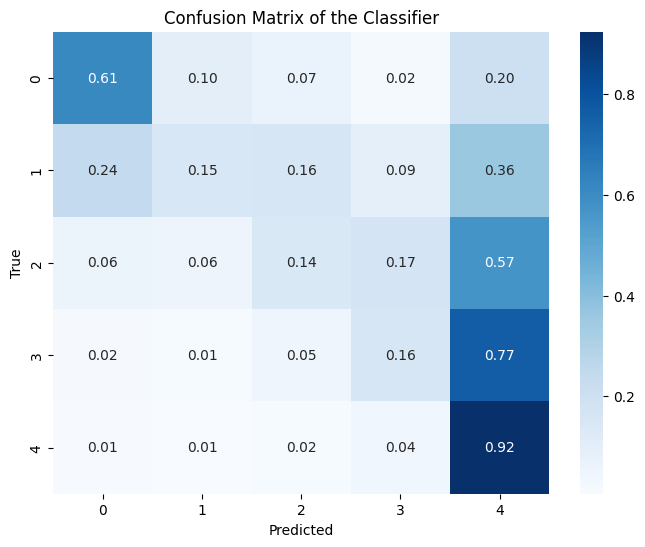

In [97]:
# Select best model and evaluate
best_hg_model = grid_search.best_estimator_
y_pred = best_hg_model.predict(X_test)

# Accuracy and Confusion Matrix
accuracy = accuracy_score(y_test, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2f")
plt.title('Confusion Matrix of the Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Submission

In [98]:
X_submission['Score'] = best_hg_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("/content/drive/My Drive/CS 506/midterm/submission.csv", index=False)
print("Submission file saved as '/content/drive/My Drive/CS 506/midterm/submission.csv'")


Submission file saved as '/content/drive/My Drive/CS 506/midterm/submission.csv'


In [99]:
submission.shape

(212192, 2)